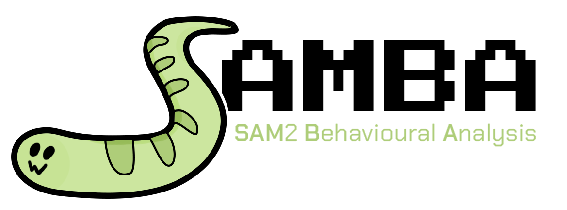

# SAMBA: **SAM**2 **B**ehavioural **A**nalysis

Use this notebook to run SAMBA on your video recordings. No coding knowledge necessary!

The instructions will guide you in connecting this notebook to a personal Google Drive account where you can upload your videos, and where SAMBA will store the results.

To use SAMBA, create a copy of this notebook in File > Save as copy in Drive.

Every time you start a new session (connect to a GPU) in the Google Colaboratory environment, you have to run all steps starting from Step 1. If the session has not disconnected, feel free to continue from the Analysis Option A or B sections after each run.

**Steps**

Run the following steps in order:

SAMBA features single video analysis or batch processing - Proceed with either Analysis Option A or B.

* [First: Instructions for selecting a GPU](#step-0)
* [Step 1: Set-up environment](#step-1)
* [Step 2: Set-up working directory](#step-2)
* [Step 3: Calibration](#step-3)
* [Analysis Option A - Single video](#analysis-a)
* [Analysis Option B - Batch processing](#analysis-b)

To run the code in a cell, either click inside it and press Ctrl + Enter, or hover your mouse over the [ ] icon and press play.

Step 1.1, 1.2, and 1.3 can be run in their entireties by collapsing their respective sections. Click the little arrows so they look like '>' and run all code cells in that step:

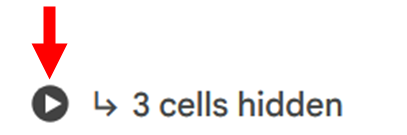

Then, run all the code blocks in step 1.

<a name="step-0"></a>

## First: Selecting a GPU


Follow the steps to select a GPU. **L4 GPU** (cost effective) or **A100** (fastest) are recommended.

Approximate processing times for a 3-minute video:

A100 GPU - 20 minutes

L4 GPU - 30 minutes

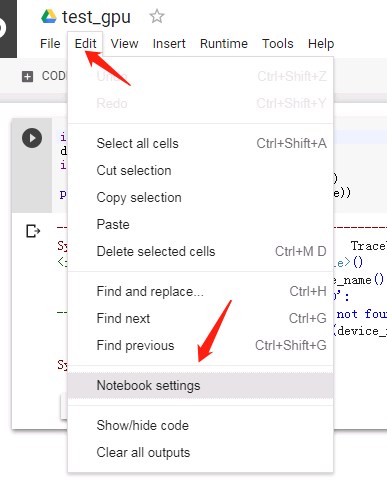

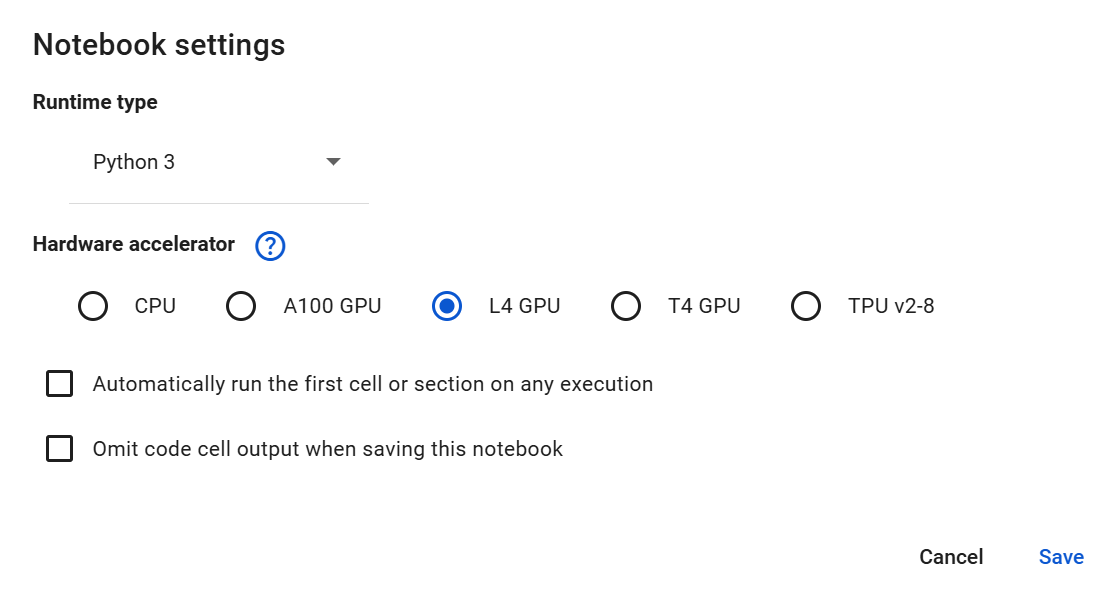

<a name="step-1"></a>

## Step 1: Set-up environment

Here we ensure the appropriate environment is set up for SAMBA to run, and define some helper functions that will be utilised in this notebook.

### 1.1 Install Python libraries and download SAM2 model (~6 mins)

The code cells below will install the necessary Python libraries to ensure SAMBA can run, and download the model weights that SAM2 requires.

There is currently a small bug in Google Colab that makes the interactive interface (when clicking on objects in a frame) not work. As such, we have code that will automatically restart the notebook session and correct this error. You can safely ignore the warnings that are produced when the notebook automatically restarts.

In [ ]:
# Install Python libraries
!pip install -q torch==2.5.1 torchvision==0.20.1 --index-url https://download.pytorch.org/whl/cu124
!pip install -q opencv-python==4.11.0.86 ffmpeg-python==0.2.0 ipympl==0.9.7 matplotlib==3.10.0

# Make code needed to run SAM2 accessible
!pip install -q 'git+https://github.com/johnsonflygroup/sam2-larvae.git'

In [ ]:
# Download SAM2 model weights
!wget -q -P ./sam2_checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/072824/sam2_hiera_large.pt

In [ ]:
# Restart session to enable clicking on objects
# Related Colab issue: https://github.com/googlecolab/colabtools/issues/5425
get_ipython().kernel.do_shutdown(restart=True);

### 1.2 Import essential modules

Once the libraries have been installed, we need to import them to make them usable within the notebook.

The second code cell below will ensure that GPU acceleration is enabled (This is required to run SAMBA).

In [ ]:
import os
import shutil
import warnings

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from sam2.build_sam import build_sam2_video_predictor
from sam2.utils.utils import (
    get_video_info, extract_frames_ffmpeg, get_video_segments,
    get_frame_data_subset, add_raw_data, process_raw_data, get_aggregated_data,
    write_raw_data, write_aggregated_data, draw_track, draw_on_video)

# Enable clicking objects in a frame
from google.colab import output
output.enable_custom_widget_manager()
%matplotlib widget

# Filter out warnings from SAM2
warnings.filterwarnings('ignore')

In [ ]:
# Ensure a GPU is available and set up GPU configuration options
if not torch.cuda.is_available():
    raise RuntimeError(
        '[WARNING] No GPU was detected. A GPU is required to run SAMBA.\n' \
        'If using Google Colab, follow the steps outlined in the "Selecting a GPU" section.')
device = torch.device('cuda')

# use bfloat16 for the entire notebook
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()

# turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

### 1.3 Set-up helper functions

Here we define a series of helper functions that SAMBA needs to process video data. Once defined, these are reused later in the notebook.

In [ ]:
def track(
        video_path, frame_index, h, w, clicked_points,
        processing_fps=None,
        sam2_checkpoint='sam2_checkpoints/sam2_hiera_large.pt',
        model_cfg='sam2_hiera_l.yaml',
):
    """Performs object tracking on a video.
    """
    # Extract the video file name without extension
    file_name = os.path.splitext(os.path.basename(video_path))[0]
    frames_dir = f'temp/{file_name}'

    # Extract individual frames from the video
    extract_frames_ffmpeg(video_path, frames_dir, fps=processing_fps)

    # Initialise the SAM2 model for predicting
    predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device, apply_postprocessing=True)
    inference_state = predictor.init_state(video_path=frames_dir, offload_video_to_cpu=True, offload_state_to_cpu=True, async_loading_frames=True)

    prompts = {}                    # Hold all the clicks we add for visualisation
    ann_frame_idx = frame_index     # The frame index we interact with

    # Initialise the state with clicked points
    ann_obj_ids = list(range(len(clicked_points)))
    for clicked_point, ann_obj_id in zip(clicked_points, ann_obj_ids):
        points = np.array([clicked_point], dtype=np.float32)
        # for labels, `1` means positive click and `0` means negative click
        labels = np.array([1], np.int32)
        prompts[ann_obj_id] = points, labels
        _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
            inference_state=inference_state,
            frame_idx=ann_frame_idx,
            obj_id=ann_obj_id,
            points=points,
            labels=labels,
        )

    # Run the model on the entire video
    video_segments = get_video_segments(predictor, inference_state, h, w)

    # Tidy-up to reduce memory constraints
    import gc
    del predictor, inference_state
    gc.collect()
    torch.cuda.empty_cache()

    # Delete extracted frames
    try:
        # Delete the folder and its contents
        shutil.rmtree(frames_dir)
        print(f"Folder '{frames_dir}' deleted successfully.")
    except OSError as e:
        print(f"Error deleting folder: {e}")

    return video_segments

In [ ]:
def generate_output(
        video_segments, video_path, out_dir, fps, scale_factor, h, w,
        frame_count, csv_dir='csv', frame_csv_dir='raw_frames',
        paths_dir='paths', speeds_dir='speeds', sizes_dir='sizes',
        out_video_name='tracking.mp4', bent_state_std_threshold=0.5,
):
    """Generates the output overlay video.
    """
    # Calculate per frame data
    frame_data = get_frame_data_subset(video_segments, step=1)
    frame_data = add_raw_data(frame_data, fps=fps, scale_factor=scale_factor, std_threshold=bent_state_std_threshold)

    # Identify any problematic frames
    good_data, bad_data = process_raw_data(
        frame_data,
        # Stage 1
        zero_run_length=ZERO_SIZE_DIFF_FRAMES,
        # Stage 2
        size_diff_thresh=SPIKE_SIZE_DIFF_THRESH, size_diff_infill_frames=SPIKE_SIZE_DIFF_INFILL_FRAMES,
        # Stage 3
        drift_signal_ksize=DRIFT_KSIZE, drift_diff_ksize=DRIFT_DIFF_KSIZE, drift_min_len=DRIFT_DURATION,
        drift_dir_frac=DRIFT_DIRECTION_FRACTION, drift_median_signal_diff_thresh=DRIFT_DETECTED_DIFF_THRESH,
        drift_infill_frames=DRIFT_INFILL_FRAMES,
        # Stage 4
        segment_median_diff_thresh=SEGMENT_MED_DIFF_THRESH, baseline_segment_min_len=SEGMENT_BASELINE_DURATION,
        # Stage 5
        size_std_thresh=OUTLIER_SIZE_STD, speed_std_thresh=OUTLIER_SPEED_STD, size_speed_infill_frames=OUTLIER_SIZE_SPEED_INFILL_FRAMES,
        # Stage 6
        final_infill_frames=FINAL_INFILL_FRAMES,
        # Overlaps
        overlap_gap_fill=OVERLAP_INFILL_FRAMES,
        overlap_min_duration=OVERLAP_MIN_DURATION,
        # Output
        out_dir=os.path.join(out_dir, 'problematic_frames_visualisation'),
    )

    # Calculate aggregated per frame data
    aggregated_frame_data = get_aggregated_data(good_data, bad_data, fps=fps, scale_factor=scale_factor)

    # Save data to csv files
    write_raw_data(out_dir, frame_csv_dir, frame_data, index_label='frame')
    write_raw_data(out_dir, 'good_frames', good_data, index_label='frame')
    write_raw_data(out_dir, 'problematic_frames', bad_data, index_label='frame')
    write_aggregated_data(out_dir, aggregated_frame_data, fname='output.csv')

    # Draw tracks
    draw_track(out_dir, paths_dir, video_segments, h, w)

    # Draw on video
    draw_on_video(video_path, out_dir, out_video_name, video_segments, fps, h, w)

In [ ]:
def manual_pipeline(
        video_path, scale_factor, clicked_points, frame_index=0,
        processing_fps=None, base_out_dir='out',
        out_video_name='tracking.mp4', bent_state_std_threshold=0.5,
):
    """Apply the pipeline on a single video.

    processing_fps is the framerate that the video should be processed at.
    If not given, uses the original video framerate.
    frame_index is assumed to be relative to the processing_fps.
    """
    # Create directory for outputs
    file_name = os.path.splitext(os.path.basename(video_path))[0]
    out_dir = os.path.join(base_out_dir, file_name)
    if os.path.exists(out_dir):
        print(f'{out_dir} exists')
        return out_dir
    os.makedirs(out_dir, exist_ok=True)

    # Get video information
    w, h, fps, frame_count = get_video_info(video_path)

    # Perform tracking
    video_segments = track(video_path, frame_index, h, w, clicked_points=clicked_points, processing_fps=processing_fps)

    # Generate all outputs (set based on processing fps)
    data_fps = processing_fps if processing_fps is not None else fps
    generate_output(video_segments, video_path, out_dir, data_fps, scale_factor,
                    h, w, frame_count, out_video_name=out_video_name,
                    bent_state_std_threshold=bent_state_std_threshold)

    return out_dir

In [ ]:
def manual_pipeline_for_directory(
        directory_path, scale_factor, clicked_points_for_videos,
        processing_fps=None, base_out_dir='out',
        error_log_path="error_log.txt", bent_state_std_threshold=0.5,
):
    """Apply the pipeline to a directory of videos.
    """
    # Create the output directory if it doesn't exist
    os.makedirs(base_out_dir, exist_ok=True)

    # Open the error log file in write mode to log exceptions
    with open(error_log_path, "w") as error_log:
        # Process each video
        for filename, values in clicked_points_for_videos.items():
            print(f'Processing {filename}')

            frame_index = values['frame_index']
            clicked_points = values['clicked_points']
            video_path = os.path.join(directory_path, filename)

            try:
                manual_pipeline(
                    video_path, scale_factor=scale_factor, clicked_points=clicked_points,
                    frame_index=frame_index, processing_fps=processing_fps,
                    base_out_dir=base_out_dir, out_video_name='tracking.mp4',
                    bent_state_std_threshold=bent_state_std_threshold)
            except Exception as e:
                # Log the filename and the exception
                error_log.write(f"{filename} failed. Exception: {str(e)}\n")
                print(f"{filename} failed. Exception: {str(e)}\n")

In [ ]:
# Set-up calibration
def calibration_on_click(event):
    """Function to capture click events.
    """
    if event.inaxes is not None:
        # Store the clicked coordinates
        clicks.append((event.xdata, event.ydata))

        # Mark the point on the image
        plt.plot(event.xdata, event.ydata, marker='.', color='red', markersize=5)

        # Refresh the plot
        plt.draw()

        print(f"Clicked at: ({event.xdata}, {event.ydata})")

        # Once we have two clicks, calculate the scale factor
        if len(clicks) == 2:
            # Disconnect the click event
            plt.gcf().canvas.mpl_disconnect(cid)

            # Calculate the scale factor
            global pixel_distance
            pixel_distance = get_pixel_distance(clicks[0], clicks[1])
            plt.close()  # Close the plot after the second click

def get_pixel_distance(point1, point2):
    """Calculate the scale factor based on two points.
    """
    # Calculate pixel distance between the two points
    pixel_distance = ((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)**0.5
    print(f"Pixel distance: {pixel_distance}")
    return pixel_distance

def calibrate(calibration_video_path):
    """Show the video frame for calibration.
    """
    # Open the video file
    cap = cv2.VideoCapture(calibration_video_path)

    # Load the first frame
    _, im0 = cap.read()
    im0 = cv2.cvtColor(im0, cv2.COLOR_BGR2RGB)

    # Close the video file
    cap.release()

    # Create a figure and display the image
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.set_title('Click 2 points to calibrate scale factor.')
    ax.imshow(im0)

    # Connect the click event handler to the plot
    global cid
    cid = fig.canvas.mpl_connect('button_press_event', calibration_on_click)

    # Show the plot and wait for two clicks
    plt.show()

In [ ]:
# Set-up manual pipeline
def object_on_click(event):
    """Function to capture click events.
    """
    # Get the x and y coordinates
    x, y = event.xdata, event.ydata

    # Store the coordinates
    if x is not None and y is not None:
        print(f"Clicked at: ({event.xdata}, {event.ydata})")

        clicked_points.append([x, y])

        # Mark the point on the image
        plt.plot(x, y, marker='.', color='red', markersize=5)

        # Refresh the plot
        plt.draw()

def show_frame(calibration_video_path, target_frame_index, target_fps=None):
    """Show the video frame.

    The frame index is based on the target fps.
    If the target fps is not given, it assumes the original video fps.
    """
    # Open the video file
    cap = cv2.VideoCapture(calibration_video_path)

    # Convert the frame_index to be based on the video at target_fps if required.
    original_fps = cap.get(cv2.CAP_PROP_FPS)
    if target_fps is not None:
        # Assume frame_index at target_fps, so convert back to original_fps
        frame_index = round(target_frame_index * (original_fps / target_fps))
    else:
        frame_index = target_frame_index
        target_fps = cap.get(cv2.CAP_PROP_FPS)

    num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if frame_index >= num_frames:
        target_num_frames = round(num_frames * (target_fps / original_fps))
        print(f'[WARNING] Requested frame index: {target_frame_index} which is equal or beyond the number of video frames ({target_num_frames}) '\
              f'at {target_fps} FPS. Request a different frame index.')
        return

    # Set frame position
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)

    # Read frame at specified position
    _, im0 = cap.read()
    im0 = cv2.cvtColor(im0, cv2.COLOR_BGR2RGB)

    # Close the video file
    cap.release()

    # Create a figure and display the image
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.imshow(im0)
    ax.set_title(f'Frame {target_frame_index}. Click on each object to be tracked.')

    # Connect the click event to the onclick function
    cid = fig.canvas.mpl_connect('button_press_event', object_on_click)

    # Display the image and wait for clicks
    plt.show()

### 1.4 Set processing framerate

If you want to reduce the number of frames processed in your videos, which can make SAMBA run faster, you can set a custom framerate in the cell below.

Enter a value (for example, `10` for ten frames per second). If you leave it as `None`, the videos are processed at their original framerate.

In [ ]:
PROCESSING_FPS = None

### 1.5 Outlier detection

There are multiple stages of outlier detection applied to identify different scenarios where SAMBA may make poor predictions. Frames flagged as 'problematic'/'outliers' are not included in the final statistic computation for each object. The default thresholds below have been selected based on 30fps videos containing 5x larvae. For 10fps video, you may need to reduce the `FRAMES`, `KSIZE`, and `DURATION` values by a factor of 3.

You can refer to our paper for a more detailed description of our outlier detection algorithm.

In [ ]:
# 1. Detecting stationary objects
ZERO_SIZE_DIFF_FRAMES = 20

# 2. Detecting spikes in object size
SPIKE_SIZE_DIFF_THRESH = 1
SPIKE_SIZE_DIFF_INFILL_FRAMES = 20

# 3. Detecting slow drifts in object size
DRIFT_KSIZE = 201
DRIFT_DIFF_KSIZE = 11
DRIFT_DURATION = 80
DRIFT_DIRECTION_FRACTION = 0.75
DRIFT_DETECTED_DIFF_THRESH = 1
DRIFT_INFILL_FRAMES = 20

# 4. Detecting separate objects in the same track
SEGMENT_MED_DIFF_THRESH = 1
SEGMENT_BASELINE_DURATION = 200

# 5. Outlier detection based on mean/std size/speed statistics
OUTLIER_SIZE_STD = 4
OUTLIER_SPEED_STD = 5
OUTLIER_SIZE_SPEED_INFILL_FRAMES = 20

# 6. Final outlier infilling
FINAL_INFILL_FRAMES = 20

### 1.6 Overlap detection

Set thresholds to help detect when multiple tracks are associated to the same object. When this occurs, SAMBA will automatically assign the overlapping track to the object it most likely belongs to.

In [ ]:
OVERLAP_INFILL_FRAMES = 20
OVERLAP_MIN_DURATION = 100

### 1.7 Bent state detection

Set a threshold for identifying whether an object is in a bent state. This has been specifically configured for SAMBA to consider a Drosophila L3 larva to be in a bent state. See our publication for further details.

In [ ]:
BENT_STATE_STD = 0.8

<a name="step-2"></a>

## Step 2: Set-up working directory

### 2.1 Connect Google Drive

Running the next cell will link SAMBA to Google Drive, accept permisions when asked.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

<a name="step-2-2"></a>

### 2.2 Set main directory

Create a project directory in Google Drive and then provide the path.

For example, my project folder on Google Drive is **MyDrive/2024/larvatracking**. Don't modify the */content/drive/* part of the path.

Once created, the second code cell will create two subfolders:
* `data/`: Where you can store your input videos to be processed.
* `out/`: Where all SAMBA outputs will be stored. For each video processed, a folder with that videos name will be created.

In [ ]:
# Update this to a directory in your Google Drive folder
MAIN_DIR = '/content/drive/MyDrive/2024/larvatracking'

In [ ]:
# Create folders
os.makedirs(os.path.join(MAIN_DIR, 'data'), exist_ok=True)
os.makedirs(os.path.join(MAIN_DIR, 'out'), exist_ok=True)

<a name="step-3"></a>

## Step 3: Calibration

### 3.1 Set scale factor if known

If the scale factor (mm/pixel) is known, you can set it here and move to the analysis.

Otherwise, set it to 0 to continue with the calibration process.

In [ ]:
#Enter scale factor if known, type '0' if unknown
scale_factor = 0

print(f"Scale factor: {scale_factor} mm/pixel")
if scale_factor == 0:
    print(f"Please proceed to the calibration steps")

### 3.2 Calibrating: Scale factor unknown

**Select calibration video**

Set the path of the video you want to use to calibrate (find mm/pixel).
The directory is in relation to the main directory set in [step 2.2](#step-2-2)




In [ ]:
# Set this to your video for calibration
calibration_video_path = f'{MAIN_DIR}/data/video/test.mp4'

The first frame of the video will be shown. Click on 2 points where you know the physical measurement, i.e. a ruler in the frame or the arena diameter.

In [ ]:
# Variables to store the clicked points
clicks = []
pixel_distance = None

if not scale_factor:
    scale_factor = calibrate(calibration_video_path)

Run this cell, then when prompted, enter the known distance in mm.

In [ ]:
if not scale_factor:
    # get real-world distance between the two points
    real_world_distance = float(input('Enter real-world distance, in millimeters: '))  # Adjust as needed

    # Calculate the scale factor (real-world units per pixel)
    scale_factor = real_world_distance / pixel_distance
    print(f"Scale factor: {scale_factor} mm/pixel")

<a name="analysis-a"></a>

## Analysis Option A - Single video

This section enables you to perform analysis on a single video at a time. If you have a folder of videos, [Analysis Option B](#analysis-b) will be more appropriate.

### A.1 Select video and output location

Update `video_path` in the code cell below to point to the video you want to process.

You can also update the default output location (`base_out_dir`) if you would rather store outputs in a different location. Note that a folder will be created inside this location for the specific video being processed.

In [ ]:
# Update the video path to the video you want to process
video_path = f'{MAIN_DIR}/data/video/test.mp4'
base_out_dir = f'{MAIN_DIR}/out'

### A.2. Select objects to track

Click on the objects you would like to track.

If objects are overlapping in the first frame, change `frame_index = ` to any subsequent frame number and re-run the code cell.

In [ ]:
# The frame number to use to select object locations
frame_index = 0

# A list to store coordinates of clicked points
clicked_points = []
show_frame(video_path, frame_index, target_fps=PROCESSING_FPS)

### A.3 Perform tracking

In [ ]:
video_output_directory = manual_pipeline(
    video_path, scale_factor, clicked_points, frame_index=frame_index,
    processing_fps=PROCESSING_FPS, base_out_dir=base_out_dir,
    bent_state_std_threshold=BENT_STATE_STD)

print(f'\nOutputs stored to: {video_output_directory}')

<a name="analysis-b"></a>

## Analysis Option B - Batch processing

This section enables you to perform analysis on a folder of videos at once. If you only have a single video, [Analysis Option A](#analysis-a) will be more appropriate.

### B.1 Select video directory and output location

Update `video_directory` in the code cell below to point to the directory containing videos you want to process.

You can also update the default output location (`base_out_dir`) if you would rather store outputs in a different location. Note that a folder will be created inside this location for the each video being processed.


In [ ]:
# Update the video directory to the one containing all videos you want to process
video_directory = f'{MAIN_DIR}/data/video/sarah/test'
base_out_dir = f'{MAIN_DIR}/out/sarah'

### B.2 Select objects to track

You will need to select objects in a frame for each of the videos you wish to process.

The code cell below will first find all videos that are to be processed.

In [ ]:
# Create a store for the objects clicked per-video
clicked_points_for_videos = {}

# Search for all video files in directory
video_fnames = sorted([f for f in os.listdir(video_directory)
                       if f.lower().endswith(('.mp4', '.avi', '.mov', '.mkv'))])

if len(video_fnames) == 0:
    print(f'[WARNING]: No videos found in {video_directory}. Please ensure the directory is typed correctly.')

# Look at all videos to be processed
print(f'Found {len(video_fnames)} videos to process.')
for vid_idx, name in enumerate(video_fnames):
    print(f'Video {vid_idx + 1}: {name}')

Now, you will need to select objects in each of the videos to be processed one-by-one. The output from the code cell above will let you know how many videos were identified.

Start by setting `video_to_process` below to 1, and select objects in the frame for that video. If objects are overlapping, change `frame_index = ` to any subsequent frame number and re-run the code cell.

Once done, continue to the next code cell, then come back to this code cell, add 1 to the `video_to_process` (i.e. if it was set to 1, set it to 2), and repeat the process.

Repeat this for all videos you wish to process. The code cell just below this one will let you know once all videos are ready to be processed by SAMBA.


In [ ]:
video_to_process = 1
frame_index = 0

# Check the video number is valid
if not 1 <= video_to_process <= len(video_fnames):
    print(f'Video {video_to_process} does not exist. Select a video from: [1 - {len(video_fnames)}]')
else:
    # Select the objects
    video_name = video_fnames[video_to_process - 1]
    video_path = os.path.join(video_directory, video_name)
    clicked_points = []
    show_frame(video_path, frame_index, target_fps=PROCESSING_FPS)

Run the code cell below once you've finished selecting objects in the frame of the video. This will ensure all selected points are stored for that video.

This code cell will also let you know which videos still need objects selected. Go back to the previous code cell to process any of the 'Videos remaining'. Only move to the next cell once objects have been selected in a frame for each video.

In [ ]:
clicked_points_for_videos[video_name] = {
    'frame_index': frame_index,
    'clicked_points': clicked_points.copy(),
}

videos_to_process = set(range(1, len(video_fnames) + 1))
videos_processed = set(video_fnames.index(k) + 1 for k in clicked_points_for_videos.keys())
videos_remaining = videos_to_process - videos_processed

print(f'Videos with objects selected: {sorted(videos_processed)}.\nVideos remaining: {sorted(videos_remaining)}')
if not videos_remaining:
    print('All videos have objects selected. Move to cell B.3.')

### B.3 Perform tracking

SAMBA will sequentially perform tracking on each video in the batch automatically.

In [ ]:
if not videos_remaining:
    manual_pipeline_for_directory(
        video_directory, scale_factor, clicked_points_for_videos,
        processing_fps=PROCESSING_FPS,
        base_out_dir=base_out_dir,
        error_log_path=os.path.join(base_out_dir, "error_log.txt"),
        bent_state_std_threshold=BENT_STATE_STD)

    print(f'\nOutputs stored to: {base_out_dir}')
else:
    print(f'[ERROR]: Objects have not been selected for these videos: {sorted(videos_remaining)}')